# パーセプトロンで識別関数を構成してみる

それでは，パーセプトロンで識別関数を構成してみましょう．
勾配法を使って計算することもできますが，オールドファッションな誤り訂正学習でも
できるのでそれを使ってやることにしましょう

アニメーション作成用に ffmpeg か imagemagick が必要です．
mp4 アニメは ffmpeg で，アニメーテッド gif は ImageMagick を呼び出します

In [9]:
# いつもの + アニメーション用
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns; sns.set()

import matplotlib.animation as animation

sns.set_context('talk')

# pcolormesh と pcolor の deprecated 問題を封じておく
plt.rcParams['axes.grid'] = False

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['image.cmap'] = 'plasma'

# 共通のパラメータを設定しておく
np.random.seed(12345) #乱数シード固定
# 表示用のレンジ固定
xrng=[-3, 12]
yrng=[-6, 6]


(-6.0, 6.0)

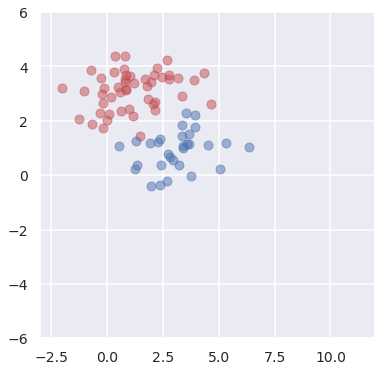

In [10]:
# まずはデータ生成から．
# ここでは２次元のガウス分布としてサンプルをばらまくので
# np.random.multivariate_normal() を使う

mu1 = np.array([1, 3])  # クラス1の中心
mu2 = np.array([3, 1])  # クラス2の中心
cov = 2 *np.array([[1.0,0.2], [0.2, 0.3]])  # 共分散行列（全クラス共通）
cov1 = cov2 = cov

N1 = 50
N2 = 30

x1 = np.random.multivariate_normal(mu1, cov1, N1)
x2 = np.random.multivariate_normal(mu2, cov2, N2)
x = np.vstack((x1, x2))

# ラベルは±1 ￥を張り付けておく
y1 = np.ones(N1)
y2 = -np.ones(N2)
y = np.hstack((y1, y2))

plt.figure(figsize=(6, 6))

plt.plot(x[y==1, 0], x[y==1, 1], 'ro', alpha=0.5)
plt.plot(x[y==-1, 0], x[y==-1, 1], 'bo', alpha=0.5)
plt.grid()

plt.xlim(xrng[0], xrng[1])
plt.ylim(yrng[0], yrng[1])

パーセプトロンの場合，重みを適当に決めてそれをベースに学習していきます

In [11]:
def predict(x, w):
    '''
    パーセプトロンの出力（±１）
    '''
    return np.sign(weight_sum(w, x))


def weight_sum(w, x):
    '''
    D入力，１出力の単純パーセプトロンの内部状態計算
    面倒なので，w は，(w0, w1, ...., wD) な D+1 次元ベクトル
    x は，N 個の入力を取り扱えるようにしておくので(N, D)な行列
    '''
    
    # x の最初の列に 1 からなるN行ベクトルを付け加えてｗを適正に扱えるようにしておく
    N = x.shape[0]
    xnew = np.hstack((np.ones((N, 1)), x))
    
    return xnew @ w   # これに np.sign をかぶせればパーセプトロンの出力


def drawfig(x, y, w, xrng=(0, 1)):
    # w0 + w1 x1 + w2 x2 = 0 が分離境界のはずなので
    # x2 = (w0 + w1 x1) / (-w2) が境界線
    xx1 = np.linspace(xrng[0], xrng[1])
    xx2 = (w[0] + w[1] * xx1) / (-w[2])
    
    im = plt.plot(xx1, xx2, 'g-', linewidth=3)
    
    return im


def update_w(w, x, t, eta=0.0001):
    ws = weight_sum(w, x)

    # x の最初の列に 1 からなるN行ベクトルを付け加えてｗを適正に扱えるようにしておく
    N = x.shape[0]
    xnew = np.hstack((np.ones((N, 1)), x))

    failset = t * ws < 0 # 教師の符号と一致しない子を抜き出す
    delta = eta * t[failset] @ xnew[failset, :]
    
    return w + delta


def Ep(w, x, t):
    '''
    コスト関数値を返す
    '''
    ws = weight_sum(w, x)
    failset = t * ws < 0
    return - weight_sum(w, x[failset,:]) @ t[failset]    

Ep 0 epochs: 53.3152211228714
Ep 1 epochs: 15.53786960491537
Ep 2 epochs: 4.26833173971332
Ep 3 epochs: 2.3772862746484407
Ep 4 epochs: 1.3128068082641582
Ep 5 epochs: 1.1841652106677776
Ep 6 epochs: 1.1612078378123818
Ep 7 epochs: 1.1382504649569871
Ep 8 epochs: 1.115293092101592
Ep 9 epochs: 1.0923357192461969
Ep 10 epochs: 1.0693783463908018
Ep 11 epochs: 1.0464209735354066
Ep 12 epochs: 1.0234636006800109
Ep 13 epochs: 1.0005062278246157
Ep 14 epochs: 0.9775488549692206
Ep 15 epochs: 0.9545914821138259
Ep 16 epochs: 0.9316341092584306
Ep 17 epochs: 0.9086767364030355
Ep 18 epochs: 0.8857193635476398
Ep 19 epochs: 0.8627619906922451
Ep 20 epochs: 0.8398046178368495
Ep 21 epochs: 0.8168472449814543
Ep 22 epochs: 0.8128877382649344
Ep 23 epochs: 0.795332284713038
Ep 24 epochs: 0.7931616077028809
Ep 25 epochs: 0.7738173244446216
Ep 26 epochs: 0.773435477140828
Ep 27 epochs: 0.7523023641762054
Ep 28 epochs: 0.753709346578775
Ep 29 epochs: 0.7325408034297431
Ep 30 epochs: 0.7322298164947

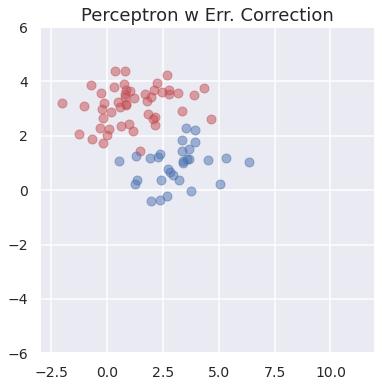

In [12]:
# よし計算してみよう

w = np.random.uniform(low=-1, high=1, size=3)

# せっかくなので途中経過をアニメーションにしておく

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==1, 0], x[y==1, 1], 'ro', alpha=0.5)
plt.plot(x[y==-1, 0], x[y==-1, 1], 'bo', alpha=0.5)
plt.title('Perceptron w Err. Correction')
plt.xlim(xrng[0], xrng[1])
plt.ylim(yrng[0], yrng[1]) 
plt.grid()

#xrng = (-3, 7) # x1 軸方向の描画範囲

ims = []
Eps = []

ims.append(drawfig(x, y, w, xrng=xrng))
Eps.append(Ep(w, x, y))
print("Ep {} epochs: {}".format(0, Ep(w, x, y)))

for n in range(200):
    w = update_w(w, x, y, eta=0.0025)
    ims.append(drawfig(x, y, w, xrng=xrng))
    Eps.append(Ep(w, x, y))
    print("Ep {} epochs: {}".format(n+1, Ep(w, x, y)))

ani = animation.ArtistAnimation(fig, ims)

In [18]:
# がんばって保存
# ffmpeg が必要
#! apt install ffmpeg
#ani.save('TmpImages/PerceptronTest.mp4', writer='ffmpeg')
ani.save('PerceptronTest.gif', writer='pillow')

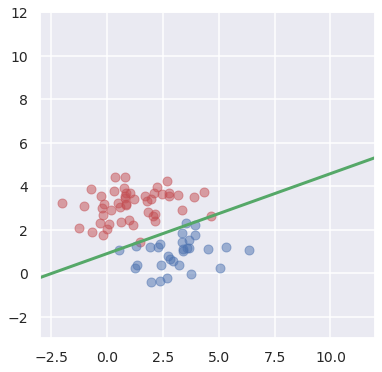

In [15]:
# 静止画での結果をとりあえず
plt.figure(figsize=(6, 6))

plt.plot(x[y==1, 0], x[y==1, 1], 'ro', alpha=0.5)
plt.plot(x[y==-1, 0], x[y==-1, 1], 'bo', alpha=0.5)

plt.grid()
plt.xlim(xrng[0], xrng[1])
plt.ylim(xrng[0], xrng[1]) 

drawfig(x, y, w, xrng=xrng)


うむ，まともそう

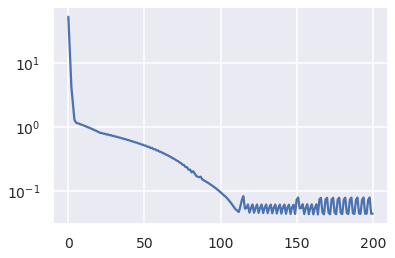

In [16]:
# コスト関数がどのように減るのかを見ておく

plt.semilogy(np.array(Eps))
plt.grid()